In [88]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


# Prepare Transforms for Data Augmentation

In [89]:
# data_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.5),  # 50% chance to shift
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=20)], p=0.5),  # 50% chance to shear
#     transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),  # 50% chance to scale
#     transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Always applied (for zoom)
#     transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
#     transforms.RandomVerticalFlip(p=0.5),  # 50% chance to flip vertically
#     transforms.ToTensor()
# ])

data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.4),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=20)], p=0.4),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.4),
        transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.4),
        transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.4),
    ]),
    transforms.ToTensor()
])

# dataset = ImageFolder(root="Dataset", transform=data_transforms)

# # Define data loader
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
# data_iter = iter(dataloader) 
# augmented_images, labels = next(data_iter)  # Ignore labels, we only need images

In [55]:
# augmented_images = augmented_images.permute(0, 2, 3, 1)

# fig, axes = plt.subplots(1, 10, figsize=(100, 50))

# for i in range(10):
#     axes[i].imshow(augmented_images[i])
#     axes[i].set_title(str(labels[i]))

# # plt.imshow(augmented_images[0])
# plt.show


# Load Training, Validation, and Testing Images

In [90]:
BATCH_SIZE = 50
DEVICE = torch.device("cuda")

train_set = ImageFolder(root="Dataset\Training", transform=data_transforms)
val_set = ImageFolder(root="Dataset\Validation", transform=data_transforms)
test_set = ImageFolder(root="Dataset\Testing", transform=data_transforms)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model Construction

In [91]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        
        conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu1 = nn.ReLU().to(DEVICE)

        pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(DEVICE)

        conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu2 = nn.ReLU().to(DEVICE)

        conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding='valid').to(DEVICE)
        relu3 = nn.ReLU().to(DEVICE)

        dropout = nn.Dropout(0.4).to(DEVICE)

        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(in_features=7200, out_features=16).to(DEVICE)
        relu4 = nn.ReLU().to(DEVICE)

        fcn2 = nn.Linear(in_features=16, out_features=4).to(DEVICE)
        softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, pool, conv2, relu2, pool, conv3, relu3, pool, dropout, flatten, fcn1, relu4, fcn2, softmax)

    def forward(self, x):
        return self.layers(x)
    

def categorical_cross_entropy(y_pred, y_true):
    return nn.NLLLoss()(torch.log(y_pred), y_true)

# Model Training

Epoch: 0
Training Loss: 1.382970
Training Loss: 1.379351
Training Loss: 1.361841
Training Loss: 1.364394
Training Loss: 1.326141
Training Loss: 1.307475
Training Loss: 1.348851
Training Loss: 1.304712
Training Loss: 1.316958
Training Loss: 1.260377
Training Loss: 1.206110
Training Loss: 1.284241
Training Loss: 1.289721
Training Loss: 1.241783
Training Loss: 1.158803
Training Loss: 1.188536
Training Loss: 1.218845
Training Loss: 1.307423
Training Loss: 1.152950
Training Loss: 1.132827
Training Loss: 1.228486
Training Loss: 1.250914
Training Loss: 1.135737
Training Loss: 1.261626
Training Loss: 1.166615
Training Loss: 1.027696
Training Loss: 1.301272
Training Loss: 1.188267
Training Loss: 1.255035
Training Loss: 1.345723
Training Loss: 1.328186
Training Loss: 1.165969
Training Loss: 1.112747
Training Loss: 1.113780
Training Loss: 1.354463
Training Loss: 1.348678
Training Loss: 1.179701
Training Loss: 1.245218
Training Loss: 1.244485
Training Loss: 1.246414
Training Loss: 1.185857
Trainin

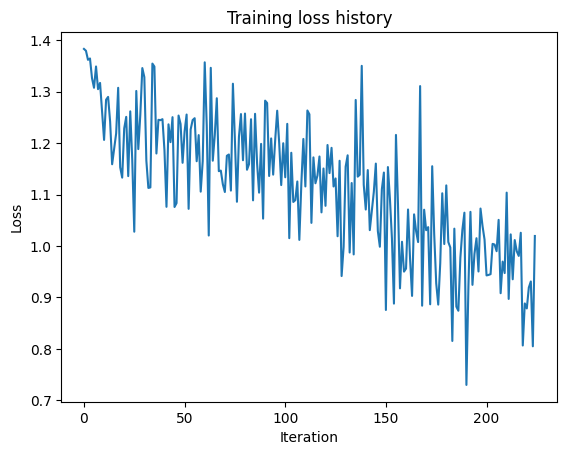

In [92]:
num_epochs = 1000
learning_rate = 0.0001
adam_beta1 = 0.9
adam_beta2 = 0.999

model = DeepCNN()

model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2))
# criterion = nn.CrossEntropyLoss()

epoch_loss = []
train_loss = []
# val_acc = []

for epoch in range(5):
    print("Epoch: %d" % epoch)
    step_num = 0
    for batch, labels in train_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        
        pred = model(batch)
        optimizer.zero_grad()
        loss = categorical_cross_entropy(y_pred=pred, y_true=labels)
        # loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # step_num += 1
        # if step_num % 13 == 0:
        #     # Perform validation and store accuracy
        #     pass

        train_loss.append(loss.item())
        print("Training Loss: %f" % loss)

    epoch_loss.append(train_loss)


plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

# Model Testing

In [93]:
with torch.no_grad():
    num_correct = 0
    total = 0
    model.eval()
    for batch, labels in test_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        
        pred = model(batch)
        num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
        total += len(labels)

accuracy = (num_correct / total) * 100
print("Model accuracy: %f" % accuracy)

Model accuracy: 52.351097
